# libs

In [8]:
from os import listdir
from os.path import isfile, join
import xml.etree.ElementTree as ET
import gc

import numpy as np
import cv2

import torch
from torch.utils.data import DataLoader, Dataset

import torchvision
from torchvision import ops
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

from tqdm.notebook import tqdm

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib
%matplotlib inline

ModuleNotFoundError: No module named 'albumentations'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# data

In [ ]:
!cd drive/MyDrive/

In [ ]:
!wget https://www.dropbox.com/s/pz3724f97bm03e3/cats_and_dogs.zip?dl=1 -O cats_and_dogs.zip
!unzip -o cats_and_dogs.zip

Streaming output truncated to the last 5000 lines.
  inflating: cats_and_dogs/train/annotations/Cats_Test2000.xml  
  inflating: cats_and_dogs/train/annotations/Cats_Test2669.xml  
  inflating: cats_and_dogs/train/annotations/Cats_Test2689.xml  
  inflating: cats_and_dogs/train/annotations/Cats_Test3013.xml  
  inflating: cats_and_dogs/train/annotations/Cats_Test793.xml  
  inflating: cats_and_dogs/train/annotations/Cats_Test1816.xml  
  inflating: cats_and_dogs/train/annotations/Cats_Test3276.xml  
  inflating: cats_and_dogs/train/annotations/Cats_Test1137.xml  
  inflating: cats_and_dogs/train/annotations/Cats_Test2172.xml  
  inflating: cats_and_dogs/train/annotations/Cats_Test1644.xml  
  inflating: cats_and_dogs/train/annotations/Cats_Test225.xml  
  inflating: cats_and_dogs/train/annotations/Cats_Test1464.xml  
  inflating: cats_and_dogs/train/annotations/Cats_Test3200.xml  
  inflating: cats_and_dogs/train/annotations/Cats_Test3297.xml  
  inflating: cats_and_dogs/train/annotati

In [ ]:
class CatsAndDogsDataset:
    def __init__(self, path, transforms=None):

        self.annot_path = join(path, 'annotations')
        self.img_path = join(path, 'images')
        file_list = sorted([f for f in listdir(self.annot_path) if isfile(join(self.annot_path, f)) and '.xml' in f])
        self.image_names = []
        self.classes = []
        self.bboxes = []
        unique_classes = set()

        for file in file_list:
            with open(join(self.annot_path, file), 'r') as f:
                tree = ET.parse(f)

            root = tree.getroot()
            img_filename = root.find('filename').text
            cls = root.find('object').find('name').text
            xmin = int(root.find('object').find('bndbox').find('xmin').text)
            ymin = int(root.find('object').find('bndbox').find('ymin').text)
            xmax = int(root.find('object').find('bndbox').find('xmax').text)
            ymax = int(root.find('object').find('bndbox').find('ymax').text)

            self.image_names.append(img_filename)
            self.classes.append(cls)
            self.bboxes.append((xmin, ymin, xmax, ymax))
            unique_classes.add(cls)

        unique_classes = ['background'] + sorted(list(unique_classes))
        self.idx2name = unique_classes
        self.name2idx = {}
        for i, cls in enumerate(self.idx2name):
            self.name2idx[cls] = i

        for i in range(len(self.classes)):
            self.classes[i] = self.name2idx[self.classes[i]]

        self.classes = np.array(self.classes)
        self.bboxes = np.array(self.bboxes)

        self.transforms = transforms

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        image_id = self.image_names[idx]

        image = cv2.imread(join(self.img_path, image_id))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0

        boxes = self.bboxes[idx].reshape(1, -1)
        boxes = torch.as_tensor(boxes, dtype=torch.float32)

        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        labels = torch.tensor([self.classes[idx]]).to(dtype=torch.int64)
        iscrowd = torch.zeros_like(labels, dtype=torch.int64)

        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([idx])
        target['area'] = area
        target['iscrowd'] = iscrowd

        if self.transforms:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']

            target['boxes'] = torch.as_tensor(sample['bboxes'],dtype=torch.float32)
            target['labels'] = torch.as_tensor(sample['labels'])

        return image, target, image_id

In [ ]:
train_h = 512
train_w = 512

def getTrainTransform():
    return A.Compose([
        A.Resize(height=train_h, width=train_w, p=1),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.2),
        A.RGBShift(r_shift_limit=15/255.0, g_shift_limit=15/255.0, b_shift_limit=15/255.0, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.Blur(p=0.2),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def getValTransform():
    return A.Compose([
        A.Resize(height=train_h, width=train_w, p=1),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def getTestTransform():
    return A.Compose([
        A.Resize(height=train_h, width=train_w, p=1),
        ToTensorV2(p=1.0)
    ])

In [ ]:
dataset_train = CatsAndDogsDataset(path='cats_and_dogs/train/', transforms=getTrainTransform())
dataset_val = CatsAndDogsDataset(path='cats_and_dogs/val/', transforms=getValTransform())

In [ ]:
batch_size = 16

In [ ]:
# Custom Batching with no collate function your batch data would look like:
# [(img_0, targets_0), (img_1, targets_1), ...]
# but with the collate function it would be more like
# [(img_0, img_1), (targets_0, targets_1), ...]

def collate_fn(batch):
    return tuple(zip(*batch))

In [ ]:
train_dataloader = DataLoader(
    dataset_train,
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,
    collate_fn=collate_fn
)

val_dataloader = DataLoader(
    dataset_val,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
def display_img(img_data, fig, axes):
    for i, img in enumerate(img_data):
        if type(img) == torch.Tensor:
            img = img.permute(1, 2, 0).numpy()
        try:
            axes[i].imshow(img)
        except:
            axes.imshow(img)

    return fig, axes

def display_bbox(bboxes, fig, ax, classes=None, in_format='xyxy', color='y', line_width=3):
    if type(bboxes) == np.ndarray:
        bboxes = torch.from_numpy(bboxes)
    if classes:
        assert len(bboxes) == len(classes)
    bboxes = ops.box_convert(bboxes, in_fmt=in_format, out_fmt='xywh')
    c = 0
    for box in bboxes:
        x, y, w, h = box.numpy()
        rect = patches.Rectangle((x, y), w, h, linewidth=line_width, edgecolor=color, facecolor='none')
        ax.add_patch(rect)
        if classes:
            if classes[c] == 'pad':
                continue
            ax.text(x + 5, y + 20, classes[c], bbox=dict(facecolor='yellow', alpha=0.5))
        c += 1

    return fig, ax

In [ ]:
images, targets, image_ids = next(iter(train_dataloader))

In [ ]:
images = torch.stack(images[:2])
bboxes = torch.stack([t['boxes'] for t in targets][:2])
labels = [[dataset_train.idx2name[f] for f in t['labels']] for t in targets][:2]

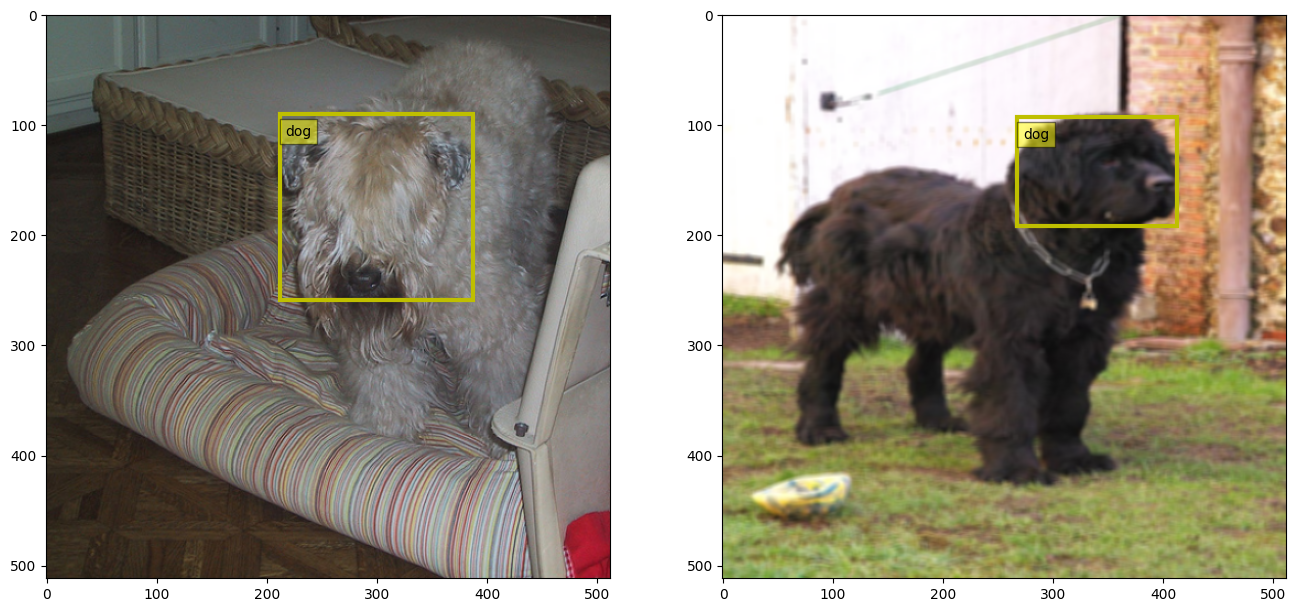

In [ ]:
nrows, ncols = (1, 2)
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))

fig, axes = display_img(images, fig, axes)
fig, _ = display_bbox(bboxes[0], fig, axes[0], classes=labels[0])
fig, _ = display_bbox(bboxes[1], fig, axes[1], classes=labels[1])

#my code

In [ ]:
!ls
!cd drive/MyDrive/ColabNotebooks

cats_and_dogs  cats_and_dogs.zip  drive  sample_data
/bin/bash: line 1: cd: drive/MyDrive/ColabNotebooks: No such file or directory


checkpoint = {  
      'epoch': epoch,  
      'model': model.state_dict(),  
      'optimizer': optimizer.state_dict(),  
      'lr_scheduler': lr_scheduler  
      }  

In [ ]:
device = 'cuda'

# model

In [ ]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(
    weights=torchvision.models.detection.FasterRCNN_ResNet50_FPN_Weights.DEFAULT)

# n_classes = len(dataset_train.idx2name)
# print(n_classes)

# Number of Input Features for the Classifier Head
num_inp_features = model.roi_heads.box_predictor.cls_score.in_features

# New Head for Classification
model.roi_heads.box_predictor = FastRCNNPredictor(num_inp_features, 2)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:02<00:00, 79.9MB/s]


In [ ]:
model.to(device=device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)

In [ ]:
# checkpoint = torch.load('checkpoint_best.pth')
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']
# lr_scheduler = checkpoint['lr_scheduler']


FileNotFoundError: [Errno 2] No such file or directory: 'checkpoint_best.pth'

In [ ]:
def calculate_iou(gt, pr, form='pascal_voc'):
    """Calculates the Intersection over Union.

    Args:
        gt: (np.ndarray[Union[int, float]]) coordinates of the ground-truth box
        pr: (np.ndarray[Union[int, float]]) coordinates of the prdected box
        form: (str) gt/pred coordinates format
            - pascal_voc: [xmin, ymin, xmax, ymax]
            - coco: [xmin, ymin, w, h]
    Returns:
        (float) Intersection over union (0.0 <= iou <= 1.0)
    """
    if form == 'coco':
        gt = gt.copy()
        pr = pr.copy()

        gt[2] = gt[0] + gt[2]
        gt[3] = gt[1] + gt[3]
        pr[2] = pr[0] + pr[2]
        pr[3] = pr[1] + pr[3]

    # Calculate overlap area
    dx = min(gt[2], pr[2]) - max(gt[0], pr[0]) + 1

    if dx < 0:
        return 0.0
    dy = min(gt[3], pr[3]) - max(gt[1], pr[1]) + 1

    if dy < 0:
        return 0.0

    overlap_area = dx * dy

    # Calculate union area
    union_area = (
            (gt[2] - gt[0] + 1) * (gt[3] - gt[1] + 1) +
            (pr[2] - pr[0] + 1) * (pr[3] - pr[1] + 1) -
            overlap_area
    )

    return overlap_area / union_area


def find_best_match(gts, pred, pred_idx, threshold = 0.5, form = 'pascal_voc', ious=None) -> int:
    """Returns the index of the 'best match' between the
    ground-truth boxes and the prediction. The 'best match'
    is the highest IoU. (0.0 IoUs are ignored).

    Args:
        gts: (List[List[Union[int, float]]]) Coordinates of the available ground-truth boxes
        pred: (List[Union[int, float]]) Coordinates of the predicted box
        pred_idx: (int) Index of the current predicted box
        threshold: (float) Threshold
        form: (str) Format of the coordinates
        ious: (np.ndarray) len(gts) x len(preds) matrix for storing calculated ious.

    Return:
        (int) Index of the best match GT box (-1 if no match above threshold)
    """
    best_match_iou = -np.inf
    best_match_idx = -1
    for gt_idx in range(len(gts)):

        if gts[gt_idx][0] < 0:
            # Already matched GT-box
            continue

        iou = -1 if ious is None else ious[gt_idx][pred_idx]

        if iou < 0:
            iou = calculate_iou(gts[gt_idx], pred, form=form)

            if ious is not None:
                ious[gt_idx][pred_idx] = iou

        if iou < threshold:
            continue

        if iou > best_match_iou:
            best_match_iou = iou
            best_match_idx = gt_idx

    return best_match_idx


def calculate_precision(gts, preds, threshold = 0.5, form = 'coco', ious=None) -> float:
    """Calculates precision for GT - prediction pairs at one threshold.

    Args:
        gts: (List[List[Union[int, float]]]) Coordinates of the available ground-truth boxes
        preds: (List[List[Union[int, float]]]) Coordinates of the predicted boxes,
               sorted by confidence value (descending)
        threshold: (float) Threshold
        form: (str) Format of the coordinates
        ious: (np.ndarray) len(gts) x len(preds) matrix for storing calculated ious.

    Return:
        (float) Precision
    """
    n = len(preds)
    tp = 0
    fp = 0

    for pred_idx in range(n):

        best_match_gt_idx = find_best_match(gts, preds[pred_idx], pred_idx,
                                            threshold=threshold, form=form, ious=ious)

        if best_match_gt_idx >= 0:
            # True positive: The predicted box matches a gt box with an IoU above the threshold.
            tp += 1
            # Remove the matched GT box
            gts[best_match_gt_idx] = -1
        else:
            # No match
            # False positive: indicates a predicted box had no associated gt box.
            fp += 1

    # False negative: indicates a gt box had no associated predicted box.
    fn = (gts.sum(axis=1) > 0).sum()

    return tp / (tp + fp + fn)


def calculate_image_precision(gts, preds, thresholds = (0.5, ), form = 'coco') -> float:
    """Calculates image precision.

    Args:
        gts: (List[List[Union[int, float]]]) Coordinates of the available ground-truth boxes
        preds: (List[List[Union[int, float]]]) Coordinates of the predicted boxes,
               sorted by confidence value (descending)
        thresholds: (float) Different thresholds
        form: (str) Format of the coordinates

    Return:
        (float) Precision
    """
    n_threshold = len(thresholds)
    image_precision = 0.0

    ious = np.ones((len(gts), len(preds))) * -1
    # ious = None

    for threshold in thresholds:
        precision_at_threshold = calculate_precision(gts.copy(), preds, threshold=threshold,
                                                     form=form, ious=ious)
        image_precision += precision_at_threshold / n_threshold

    return image_precision

In [ ]:
val_draw_images = [
    'cats_and_dogs/val/images/Cats_Test216.png',
    'cats_and_dogs/val/images/Cats_Test347.png',
    'cats_and_dogs/val/images/Cats_Test573.png',
    'cats_and_dogs/val/images/Cats_Test588.png',
    'cats_and_dogs/val/images/Cats_Test564.png',
    'cats_and_dogs/val/images/Cats_Test875.png',
    'cats_and_dogs/val/images/Cats_Test923.png',
    'cats_and_dogs/val/images/Cats_Test1265.png'
]

In [ ]:
def draw(pref, save_path, image_list):
    with torch.no_grad():
        model.eval()

        !mkdir -p {save_path}/{pref}
        for img_idx, img_filename in enumerate(image_list):
            image = cv2.imread(img_filename)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
            image /= 255.0
            init_image = image.copy()
            init_h, init_w, _ = image.shape

            init_image = init_image.transpose(2, 0, 1)
            init_image = init_image.reshape(1, *init_image.shape)
            init_image = torch.as_tensor(init_image)

            image = getTestTransform()(image=image)['image']
            image = image.view(1, *image.shape)

            output = model(image.to(device=device))
            bboxes = output[0]['boxes'].cpu()
            labels = output[0]['labels'].cpu()

            bboxes[:, 0] *= init_w / train_w
            bboxes[:, 1] *= init_h / train_h
            bboxes[:, 2] *= init_w / train_w
            bboxes[:, 3] *= init_h / train_h

            nrows, ncols = (1, 1)
            fig, axes = plt.subplots(nrows, ncols)
            fig, axes = display_img(init_image, fig, axes)

            if len(labels) == 0:
                labels = None
            else:
                labels = [dataset_train.idx2name[t.item()] for t in labels]
            fig, _ = display_bbox(bboxes, fig, axes, classes=labels)
            axes.axis('off')

            fig.savefig(f'{save_path}/{pref}/{img_idx}.png', bbox_inches='tight', pad_inches=0)
            fig.clf()
            plt.close()

In [ ]:
num_epochs = 1000

iou_thresholds = [x for x in np.arange(0.5, 0.76, 0.05)]

In [ ]:
!mkdir -p drive/MyDrive/detection

In [ ]:
epoch = 0
num_iter = 0

In [ ]:
best_value = 0.0

In [ ]:
loss_history = []
for epoch in range(num_epochs):
    model.train()
    for images, targets, image_ids in tqdm(train_dataloader):
        optimizer.zero_grad()

        images = torch.stack(images).to(device=device)
        targets = [{k: v.to(device=device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        totalLoss = sum(loss for loss in loss_dict.values())
        loss_history.append(totalLoss.item())

        totalLoss.backward()
        optimizer.step()

        if num_iter % 50 == 0:
            draw(f'epoch_{epoch}_iter_{num_iter}', 'draw/val', val_draw_images)
            model.train()
        gc.collect()
        num_iter += 1

    model.eval()
    checkpoint = {
        'epoch': epoch,
        'model': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'lr_scheduler': lr_scheduler}
    torch.save(checkpoint, f'checkpoint_epoch_{epoch}.pth')

    !cp checkpoint_epoch_{epoch}.pth drive/MyDrive/detection/checkpoint_last.pth

    with torch.no_grad():
        validation_image_precisions = []
        for _ in range(len(iou_thresholds)):
            validation_image_precisions.append([])

        for images, targets, image_ids in tqdm(val_dataloader):
            images = torch.stack(images).to(device=device)
            targets = [{k: v.to(device=device) for k, v in t.items()} for t in targets]

            outputs = model(images, targets)


            for thr_idx, thr in enumerate(iou_thresholds):
                for i, image in enumerate(images):
                    boxes = outputs[i]['boxes'].data.cpu().numpy()
                    scores = outputs[i]['scores'].data.cpu().numpy()
                    gt_boxes = targets[i]['boxes'].cpu().numpy()
                    preds_sorted_idx = np.argsort(scores)[::-1]
                    preds_sorted = boxes[preds_sorted_idx]
                    image_precision = calculate_image_precision(preds_sorted,
                                                                gt_boxes,
                                                                thresholds=[thr],
                                                                form='coco')
                    validation_image_precisions[thr_idx].append(image_precision)

        validation_image_precisions = np.array(validation_image_precisions)
        validation_image_precisions = validation_image_precisions.mean(-1)

        valid_mean_val = validation_image_precisions.mean()
        if valid_mean_val > best_value:
            best_value = valid_mean_val
            !cp checkpoint_epoch_{epoch}.pth drive/MyDrive/detection/checkpoint_best.pth

        print('===================')
        print(f'Validation, epoch {epoch}: {validation_image_precisions}')
        print('===================')

        !zip -r draw_epoch_{epoch}.zip draw
        !cp draw_epoch_{epoch}.zip drive/MyDrive/detection/

        !rm -rf draw
        !rm checkpoint_epoch_{epoch}.pth